# Pythagorean Expectation

* Relationship between winning and success of teams (as measured by point, goals, score)
* Pythagorean Expectation states that the **win % of a team over a season, is proportional to the ratio of: square of the points/runs/goals scored by the team divided by sum of squares of the points/runs/goals scored by the team and its opponents**

## 1. Pythagorean Expectation in Baseball:

### A. Preparing the Data and the Variables Needed

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
MLB = pd.read_excel("datasets/Retrosheet MLB game log 2018.xlsx")
print(MLB.columns.tolist())

['Date', 'DoubleHeader', 'DayOfWeek', 'VisitingTeam', 'VisitingTeamLeague', 'VisitingTeamGameNumber', 'HomeTeam', 'HomeTeamLeague', 'HomeTeamGameNumber', 'VisitorRunsScored', 'HomeRunsScore', 'LengthInOuts', 'DayNight', 'CompletionInfo', 'ForfeitInfo', 'ProtestInfo', 'ParkID', 'Attendence', 'Duration', 'VisitorLineScore', 'HomeLineScore', 'VisitorAB', 'VisitorH', 'VisitorD', 'VisitorT', 'VisitorHR', 'VisitorRBI', 'VisitorSH', 'VisitorSF', 'VisitorHBP', 'VisitorBB', 'VisitorIBB', 'VisitorK', 'VisitorSB', 'VisitorCS', 'VisitorGDP', 'VisitorCI', 'VisitorLOB', 'VisitorPitchers', 'VisitorER', 'VisitorTER', 'VisitorWP', 'VisitorBalks', 'VisitorPO', 'VisitorA', 'VisitorE', 'VisitorPassed', 'VisitorDB', 'VisitorTP', 'HomeAB', 'HomeH', 'HomeD', 'HomeT', 'HomeHR', 'HomeRBI', 'HomeSH', 'HomeSF', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeK', 'HomeSB', 'HomeCS', 'HomeGDP', 'HomeCI', 'HomeLOB', 'HomePitchers', 'HomeER', 'HomeTER', 'HomeWP', 'HomeBalks', 'HomePO', 'HomeA', 'HomeE', 'HomePassed', 'HomeDB',

In [3]:
MLB.head()

,Date,DoubleHeader,DayOfWeek,VisitingTeam,VisitingTeamLeague,VisitingTeamGameNumber,HomeTeam,HomeTeamLeague,HomeTeamGameNumber,VisitorRunsScored,...,HomeBatting7Name,HomeBatting7Position,HomeBatting8PlayerID,HomeBatting8Name,HomeBatting8Position,HomeBatting9PlayerID,HomeBatting9Name,HomeBatting9Position,AdditionalInfo,AcquisitionInfo
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,...,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,...,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,...,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,...,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,...,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


In [4]:
"""For the Pythagorean Expecation, we only need the runs scored and conceded"""
MLB18 = MLB[["VisitingTeam","HomeTeam","VisitorRunsScored","HomeRunsScore","Date"]]
MLB18 = MLB18.rename(columns = {"VisitorRunsScored":"VisR", "HomeRunsScore":"HomeR"})
MLB18.head()

,VisitingTeam,HomeTeam,VisR,HomeR,Date
0,COL,ARI,2,8,20180329
1,PHI,ATL,5,8,20180329
2,SFN,LAN,1,0,20180329
3,CHN,MIA,8,4,20180329
4,SLN,NYN,4,9,20180329


In [5]:
"""We will need a new column to represent who won the game. We will create 2 new columns for this: 'hwin' which will be 1 
when the home team wins, and 'awin' which will be 1 when the away team wins. In baseball, the winner is determined by the 
team that scores more runs"""
MLB18["hwin"] = np.where(MLB18["HomeR"] > MLB18["VisR"], 1, 0) #hwin = 1 when HomeR > VisR, else 0
MLB18["awin"] = np.where(MLB18["HomeR"] < MLB18["VisR"], 1, 0)
MLB18["count"] = 1 #count variable which help keep track of games played by each team (not same for all teams in MLB)
MLB18.head()

,VisitingTeam,HomeTeam,VisR,HomeR,Date,hwin,awin,count
0,COL,ARI,2,8,20180329,1,0,1
1,PHI,ATL,5,8,20180329,1,0,1
2,SFN,LAN,1,0,20180329,0,1,1
3,CHN,MIA,8,4,20180329,0,1,1
4,SLN,NYN,4,9,20180329,1,0,1


In [6]:
"""To calculate the runs scored by a team, we will have to combine the runs scored by the team when they were the Home Team, 
as well as when they were the away team! A similar aggregation will also have to be done to calcualte the runs scored 
against the team."""

#We will define 2 dfs, 1 for home teams and 1 for away teams, which we can then merge to get the stats for the entire season
MLBhome = MLB18.groupby("HomeTeam")["hwin","HomeR","VisR","count"].sum().reset_index()
MLBhome = MLBhome.rename(columns = {"HomeTeam":"team", "VisR":"VisRh", "HomeR":"HomRh", "count":"Gh"})
MLBhome.head()

<ipython-input-6-2c139d9e2ecd>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MLBhome = MLB18.groupby("HomeTeam")["hwin","HomeR","VisR","count"].sum().reset_index()


,team,hwin,HomRh,VisRh,Gh
0,ANA,42,355,355,81
1,ARI,40,359,328,81
2,ATL,43,391,357,81
3,BAL,28,339,411,81
4,BOS,57,468,322,81


In [7]:
#Create a df for the away teams
MLBaway = MLB18.groupby("VisitingTeam")["awin","HomeR","VisR","count"].sum().reset_index()
MLBaway = MLBaway.rename(columns = {"VisitingTeam":"team", "VisR":"VisRa", "HomeR":"HomRa", "count":"Ga"})
MLBaway.head()

<ipython-input-7-0448fdc7f483>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MLBaway = MLB18.groupby("VisitingTeam")["awin","HomeR","VisR","count"].sum().reset_index()


,team,awin,HomRa,VisRa,Ga
0,ANA,38,367,366,81
1,ARI,42,316,334,81
2,ATL,47,300,368,81
3,BAL,19,481,283,81
4,BOS,51,325,408,81


In [8]:
#Merge the 2 datasets
MLB18 = pd.merge(MLBhome, MLBaway, on = 'team')
MLB18.head()

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga
0,ANA,42,355,355,81,38,367,366,81
1,ARI,40,359,328,81,42,316,334,81
2,ATL,43,391,357,81,47,300,368,81
3,BAL,28,339,411,81,19,481,283,81
4,BOS,57,468,322,81,51,325,408,81


In [9]:
"""We will now create new columns for each team: Wins (W), Games played (G), Runs Scored (R) and Runs conceded (RA). These
columns will have the aggregated data for each team from their home AND away matches"""
MLB18['W'] = MLB18['hwin'] + MLB18['awin']
MLB18['G'] = MLB18['Gh'] + MLB18['Ga']

# the runs scored by the team are: Runs Scored when they were home (HomRh) + Runs scored as away teams in away matches (VisRa)
MLB18['R'] = MLB18['HomRh'] + MLB18['VisRa']

MLB18['RA'] = MLB18['VisRh'] + MLB18['HomRa']
MLB18.head()

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga,W,G,R,RA
0,ANA,42,355,355,81,38,367,366,81,80,162,721,722
1,ARI,40,359,328,81,42,316,334,81,82,162,693,644
2,ATL,43,391,357,81,47,300,368,81,90,162,759,657
3,BAL,28,339,411,81,19,481,283,81,47,162,622,892
4,BOS,57,468,322,81,51,325,408,81,108,162,876,647


In [10]:
"""Using the new data calculated, we will add 2 more columns for: Win Percentage (wpc) and Pythagorean Expectation (pyth)"""
MLB18['wpc'] = MLB18['W'] / MLB18['G']

#pyth = Runs scored by the team squared / Sum of Square of Runs Scored by the Team and its opponents 
MLB18['pyth'] = MLB18['R']**2 / (MLB18['R']**2 + MLB18['RA']**2)
MLB18.head()

,team,hwin,HomRh,VisRh,Gh,awin,HomRa,VisRa,Ga,W,G,R,RA,wpc,pyth
0,ANA,42,355,355,81,38,367,366,81,80,162,721,722,0.493827,0.499307
1,ARI,40,359,328,81,42,316,334,81,82,162,693,644,0.506173,0.536600
2,ATL,43,391,357,81,47,300,368,81,90,162,759,657,0.555556,0.571662
3,BAL,28,339,411,81,19,481,283,81,47,162,622,892,0.290123,0.327161
4,BOS,57,468,322,81,51,325,408,81,108,162,876,647,0.666667,0.647037


### B. Analysing the Data

'The plot shows that there is a strong correlation between pyth and wpc: Higher the Pythagorean Expecation = Higher the \nWin Percentage of the team'

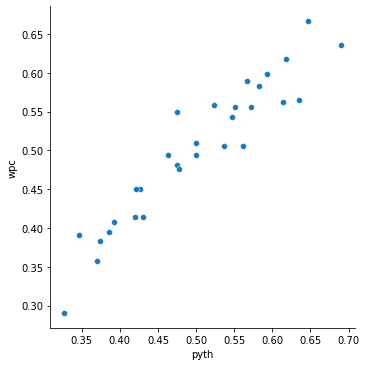

In [11]:
sns.relplot(x = 'pyth', y = 'wpc', data = MLB18)
"""The plot shows that there is a strong correlation between pyth and wpc: Higher the Pythagorean Expecation = Higher the 
Win Percentage of the team"""

In [12]:
"""Find the Relation between Win % and Pythagorean Expectation using Regression: wpc = Intercept + Coef * pyth"""
#Generate a regression model (wpc as a function of pyth)
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data = MLB18).fit() #ols = Ordinary Least Squares (standard form of Regression)
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     236.2
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           3.54e-15
Time:                        22:06:07   Log-Likelihood:                 63.733
No. Observations:                  30   AIC:                            -123.5
Df Residuals:                      28   BIC:                            -120.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0609      0.029      2.093      0.046       0.001       0.120
pyth           0.8770      0.057     15.370      0.000       0.760       0.994
==============================================================================
Omnibus:                        0.145   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.012
Skew:                          -0.009   Prob(JB):                        0.994
Kurtosis:                       2.905   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### C. Interpreting Results

* Therefore: **wpc = 0.0609 + pyth * 0.8770**
    * For every unit increase in pyth, the wpc increases by 0.877



* **Standard Error**: std err gives us an idea of the precision of the estimate
* Ratio of coeefficient (coef) to the standard error (std err) is called the **t-statistic (t)**. This value informs about the statistical significance / how reliable the data is
* The **p-value** (P > |t|) is the probability that would observe the value of 0.877 by chance.
    * If the p-value becomes very large, then we lose confidence that we have a reliable estimate. High p-value: lot of variability or noise in the relationship.
    * If the p-value becomes very small, then we have a high level of confidence that the relationship is being reliably estimated.



* **R-squared**: Represents the percentage of variation in the y-variable (wpc) which can be accounted for, by the percentage of variation in x variable (pyth). Here the Pythagorean Expecation can account for 89.4% of the variation in win percentage.
    * R-squred measures how closely the variables fit together
    * R-squared has a value between 0 and 1:
        * R-squared = 1: Perfect fit
        * R-squared = 0: No fit

#### If the p-value (P > |t|) is below 0.05: The result is usually considered reliable or statistically significant
* Here the p-value for pyth is 0.000 --> Result is reliable!

## 2. Pythagorean Expectation in Cricket:

### A. Preparing the Data and the Variables Needed

In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
IPL_18 = pd.read_excel("datasets/IPL2018teams.xlsx")
print(IPL_18.columns.tolist())

['scorecard_id', 'start_date', 'phase', 'name', 'home_team', 'away_team', 'toss_winner', 'toss_decision', 'inn1team', 'innings1', 'wickets1', 'overs1', 'closure1', 'innings2', 'wickets2', 'overs2', 'closure2', 'adjusted_target_indicator', 'adjusted_target', 'team1_overs', 'team2_overs', 'mom_player_id', 'mom_player', 'scoring_status', 'result_type', 'result_margin', 'winning_team']


In [15]:
IPL_18.head()

,scorecard_id,start_date,phase,name,home_team,away_team,toss_winner,toss_decision,inn1team,innings1,...,adjusted_target_indicator,adjusted_target,team1_overs,team2_overs,mom_player_id,mom_player,scoring_status,result_type,result_margin,winning_team
0,1056637,2018-04-07,NaN,"Wankhede Stadium, Mumbai",Mumbai Indians,Chennai Super Kings,Chennai Super Kings,f,Mumbai Indians,165,...,n,0,20.0,20,44613,DJ Bravo,live bbb,ww,1,Chennai Super Kings
1,1056638,2018-04-08,NaN,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Delhi Daredevils,Kings XI Punjab,f,Delhi Daredevils,166,...,n,0,20.0,20,170187,KL Rahul,live bbb,ww,6,Kings XI Punjab
2,1056639,2018-04-08,NaN,"Eden Gardens, Kolkata",Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,f,Royal Challengers Bangalore,176,...,n,0,20.0,20,412485,N Rana,live bbb,ww,4,Kolkata Knight Riders
3,1056640,2018-04-09,NaN,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Sunrisers,Rajasthan Royals,Sunrisers,f,Rajasthan Royals,125,...,n,0,20.0,20,15627,S Dhawan,live bbb,ww,9,Sunrisers
4,1056641,2018-04-10,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,f,Kolkata Knight Riders,202,...,n,0,20.0,20,119895,SW Billings,live bbb,ww,5,Chennai Super Kings


In [16]:
"""Add new columns to the dataset: 'hwin' (to represent if the home team won), 'awin' (to represent if the away team won),
'htruns' (runs scored by the home team), 'atruns' (runs scored by the away team) and 'count' to keep a count of the matches 
played by the team"""

IPL_18["hwin"] = np.where(IPL_18["home_team"] == IPL_18["winning_team"],1,0)
IPL_18["awin"] = np.where(IPL_18["away_team"] == IPL_18["winning_team"],1,0)

#np.where works as IF statement. If home_team = inn1team: Put htruns as innings1 runs. Else put htruns as innings2 runs.
IPL_18["htruns"] = np.where(IPL_18["home_team"] == IPL_18["inn1team"], IPL_18["innings1"], IPL_18["innings2"])

#np.where works as IF statement. If away_team = inn1team: Put atruns as innings1 runs. Else put atruns as innings2 runs.
IPL_18["atruns"] = np.where(IPL_18["away_team"] == IPL_18["inn1team"], IPL_18["innings1"], IPL_18["innings2"])

IPL_18["count"] = 1
IPL_18.head()

,scorecard_id,start_date,phase,name,home_team,away_team,toss_winner,toss_decision,inn1team,innings1,...,mom_player,scoring_status,result_type,result_margin,winning_team,hwin,awin,htruns,atruns,count
0,1056637,2018-04-07,NaN,"Wankhede Stadium, Mumbai",Mumbai Indians,Chennai Super Kings,Chennai Super Kings,f,Mumbai Indians,165,...,DJ Bravo,live bbb,ww,1,Chennai Super Kings,0,1,165,169,1
1,1056638,2018-04-08,NaN,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Delhi Daredevils,Kings XI Punjab,f,Delhi Daredevils,166,...,KL Rahul,live bbb,ww,6,Kings XI Punjab,1,0,167,166,1
2,1056639,2018-04-08,NaN,"Eden Gardens, Kolkata",Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata Knight Riders,f,Royal Challengers Bangalore,176,...,N Rana,live bbb,ww,4,Kolkata Knight Riders,1,0,177,176,1
3,1056640,2018-04-09,NaN,"Rajiv Gandhi International Stadium, Uppal, Hyd...",Sunrisers,Rajasthan Royals,Sunrisers,f,Rajasthan Royals,125,...,S Dhawan,live bbb,ww,9,Sunrisers,1,0,127,125,1
4,1056641,2018-04-10,NaN,"MA Chidambaram Stadium, Chepauk, Chennai",Chennai Super Kings,Kolkata Knight Riders,Chennai Super Kings,f,Kolkata Knight Riders,202,...,SW Billings,live bbb,ww,5,Chennai Super Kings,1,0,205,202,1


In [17]:
"""Split the dataset into performances by Home Teams and Away Teams"""
IPL_home = IPL_18.groupby("home_team")["count","hwin","htruns","atruns"].sum().reset_index()
IPL_home = IPL_home.rename(columns = {"home_team":"team", "count":"Ph", "htruns":"htrunsh", "atruns":"atrunsh"})
IPL_home.head()

<ipython-input-17-b7ac2df1912d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  IPL_home = IPL_18.groupby("home_team")["count","hwin","htruns","atruns"].sum().reset_index()


,team,Ph,hwin,htrunsh,atrunsh
0,Chennai Super Kings,9,8,1577,1486
1,Delhi Daredevils,7,4,1258,1122
2,Kings XI Punjab,7,4,1188,1202
3,Kolkata Knight Riders,9,5,1468,1417
4,Mumbai Indians,7,3,1194,1171


In [18]:
IPL_away = IPL_18.groupby("away_team")["count","awin","htruns","atruns"].sum().reset_index()
IPL_away = IPL_away.rename(columns = {"away_team":"team", "count":"Pa", "htruns":"htrunsa", "atruns":"atrunsa"})
IPL_away.head()

<ipython-input-18-ce7983252e36>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  IPL_away = IPL_18.groupby("away_team")["count","awin","htruns","atruns"].sum().reset_index()


,team,Pa,awin,htrunsa,atrunsa
0,Chennai Super Kings,7,3,1264,1232
1,Delhi Daredevils,7,1,1265,1085
2,Kings XI Punjab,7,2,1124,1022
3,Kolkata Knight Riders,7,4,1326,1291
4,Mumbai Indians,7,3,1111,1186


In [19]:
"""Merge the 2 datasets to get the records for each team: Home and Away"""
IPL18 = pd.merge(IPL_home, IPL_away, on = ['team'])
IPL18.head()

,team,Ph,hwin,htrunsh,atrunsh,Pa,awin,htrunsa,atrunsa
0,Chennai Super Kings,9,8,1577,1486,7,3,1264,1232
1,Delhi Daredevils,7,4,1258,1122,7,1,1265,1085
2,Kings XI Punjab,7,4,1188,1202,7,2,1124,1022
3,Kolkata Knight Riders,9,5,1468,1417,7,4,1326,1291
4,Mumbai Indians,7,3,1194,1171,7,3,1111,1186


In [20]:
"""We will now create new columns for each team: Wins (W), Games played (G), Runs Scored (R) and Runs conceded (RA). These
columns will have the aggregated data for each team from their home AND away matches"""

IPL18["W"] = IPL18["hwin"] + IPL18["awin"]
IPL18["G"] = IPL18["Ph"] + IPL18["Pa"]
IPL18["R"] = IPL18["htrunsh"] + IPL18["atrunsa"]
IPL18["RA"] = IPL18["atrunsh"] + IPL18["htrunsa"]
IPL18.head()

,team,Ph,hwin,htrunsh,atrunsh,Pa,awin,htrunsa,atrunsa,W,G,R,RA
0,Chennai Super Kings,9,8,1577,1486,7,3,1264,1232,11,16,2809,2750
1,Delhi Daredevils,7,4,1258,1122,7,1,1265,1085,5,14,2343,2387
2,Kings XI Punjab,7,4,1188,1202,7,2,1124,1022,6,14,2210,2326
3,Kolkata Knight Riders,9,5,1468,1417,7,4,1326,1291,9,16,2759,2743
4,Mumbai Indians,7,3,1194,1171,7,3,1111,1186,6,14,2380,2282


In [21]:
"""Using the new data calculated, we will add 2 more columns for: Win Percentage (wpc) and Pythagorean Expectation (pyth)"""
IPL18['wpc'] = IPL18['W'] / IPL18['G']

#pyth = Runs scored by the team squared / Sum of Square of Runs Scored by the Team and its opponents 
IPL18['pyth'] = IPL18['R']**2 / (IPL18['R']**2 + IPL18['RA']**2)
IPL18.head()

,team,Ph,hwin,htrunsh,atrunsh,Pa,awin,htrunsa,atrunsa,W,G,R,RA,wpc,pyth
0,Chennai Super Kings,9,8,1577,1486,7,3,1264,1232,11,16,2809,2750,0.687500,0.510612
1,Delhi Daredevils,7,4,1258,1122,7,1,1265,1085,5,14,2343,2387,0.357143,0.490698
2,Kings XI Punjab,7,4,1188,1202,7,2,1124,1022,6,14,2210,2326,0.428571,0.474444
3,Kolkata Knight Riders,9,5,1468,1417,7,4,1326,1291,9,16,2759,2743,0.562500,0.502908
4,Mumbai Indians,7,3,1194,1171,7,3,1111,1186,6,14,2380,2282,0.428571,0.521012


### B. Analysing the Data

'Lesser teams than baseball = Fewer points = Harder to discern any relationship + The points are Scattered'

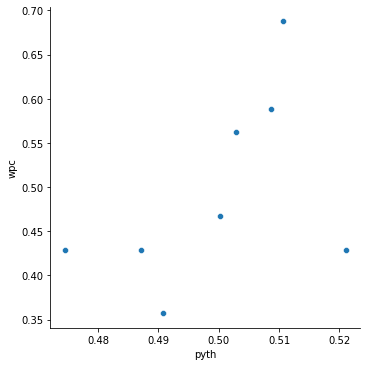

In [22]:
sns.relplot(x = "pyth", y = "wpc", data = IPL18)

"""Lesser teams than baseball = Fewer points = Harder to discern any relationship + The points are Scattered"""

In [23]:
"""Find the Relation between Win % and Pythagorean Expectation using Regression: wpc = Intercept + Coef * pyth"""
#Generate a regression model (wpc as a function of pyth)
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data = IPL18).fit() #ols = Ordinary Least Squares (standard form of Regression)
pyth_lm.summary()

c:\users\samsung\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     1.830
Date:                Wed, 24 Nov 2021   Prob (F-statistic):              0.225
Time:                        22:06:09   Log-Likelihood:                 7.9710
No. Observations:                   8   AIC:                            -11.94
Df Residuals:                       6   BIC:                            -11.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2807      1.312     -0.976      0.367      -4.491       1.929
pyth           3.5522      2.626      1.353      0.225      -2.872       9.977
==============================================================================
Omnibus:                        0.002   Durbin-Watson:                   2.254
Prob(Omnibus):                  0.999   Jarque-Bera (JB):                0.217
Skew:                           0.014   Prob(JB):                        0.897
Kurtosis:                       2.193   Cond. No.                         89.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### C. Interpreting Results

* Therefore: **wpc = -1.2807 + pyth * 3.5522**
    * For every unit increase in pyth, the wpc increases by 3.5522



* **Standard Error**: std err gives us an idea of the precision of the estimate
    * Here the standard error is very large (2.626)



* The p-value (P > |t|) is 0.225
    * Since p-value > 0.05 --> This value is considered statistically insignificant --> **There is no statistical significance between Pythagorean Expectation and Win Percentage based on this dataset**



* The R-squared value is very small (0.234), which again highlights that we don't have a reliable relationship between wpc and pyth

**Possible Interpretations:**
* The dataset size for cricket is much smaller than the dataset used for MLB [fewer games and fewer teams]. Maybe There is a relationship between wpc and pyth in IPL, but we don't have enough data for it
* Maybe the difference is due to the difference in the structure of the games:
    * In cricket, if the team batting first wins, the difference between runs scored by both teams will be anywhere between 1 to the number of runs scored by the 1st team.
    * BUT, if the team batting second wins, the difference between the runs scored by both teams will mostly be 1 (since the team batting second stops batting after they score more runs than the 1st team).
    * This leads to an assymetry in the relationship!

## 3. Pythagorean Expectations in EPL

### A. Preparing the Data and the Variables Needed

In [24]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
"""The dataset contains data from teams from PL, Championship, League 1 and League 2 in England"""
Eng18 = pd.read_excel("datasets/EngSoccer2017-18.xlsx")
Eng18.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H


In [26]:
Eng18.tail()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
2031,FL2,2018-05-05 00:00:00,Lincoln,Yeovil,1,1,D
2032,FL2,2018-05-05 00:00:00,Mansfield,Crawley Town,1,1,D
2033,FL2,2018-05-05 00:00:00,Notts County,Luton,0,0,D
2034,FL2,2018-05-05 00:00:00,Swindon,Accrington,3,0,H
2035,FL2,2018-05-05 00:00:00,Wycombe,Stevenage,1,0,H


In [27]:
"""Unlike the previous sports, draw is a common result in the Football. The Result (FTR) can be Home Win (H), Away Win (A) 
or Draw (D). So we will create 2 new columns: hwinvalue (1 when home team wins, 0 when the away team wins, 0.5 when its a draw) 
and awinvalue"""
Eng18["hwinvalue"] = np.where(Eng18["FTR"] == "H", 1, np.where(Eng18["FTR"] == "D", 0.5, 0))
Eng18["awinvalue"] = np.where(Eng18["FTR"] == "A", 1, np.where(Eng18["FTR"] == "D", 0.5, 0))
Eng18["count"] = 1
Eng18.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,hwinvalue,awinvalue,count
0,EPL,2017-11-08 00:00:00,Arsenal,Leicester,4,3,H,1.0,0.0,1
1,EPL,2017-12-08 00:00:00,Brighton,Man City,0,2,A,0.0,1.0,1
2,EPL,2017-12-08 00:00:00,Chelsea,Burnley,2,3,A,0.0,1.0,1
3,EPL,2017-12-08 00:00:00,Crystal Palace,Huddersfield,0,3,A,0.0,1.0,1
4,EPL,2017-12-08 00:00:00,Everton,Stoke,1,0,H,1.0,0.0,1


In [28]:
"""Here again, we have 1 row for each game. So we will again have to split the dataset into Home and Away, and aggregrate 
the results. We do this because we need to measure the performance of each team, at home and away games!"""
Enghome = Eng18.groupby(["HomeTeam","Div"])["count","hwinvalue","FTHG","FTAG"].sum().reset_index()
Enghome = Enghome.rename(columns = {"HomeTeam":"team", "count":"Ph", "FTHG":"FTHGh", "FTAG":"FTAGh"})
Enghome

<ipython-input-28-3ad2311d4736>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Enghome = Eng18.groupby(["HomeTeam","Div"])["count","hwinvalue","FTHG","FTAG"].sum().reset_index()


,team,Div,Ph,hwinvalue,FTHGh,FTAGh
0,AFC Wimbledon,FL1,23,11.0,25,30
1,Accrington,FL2,23,18.5,42,19
2,Arsenal,EPL,19,16.0,54,20
3,Aston Villa,FLCH,23,17.5,42,19
4,Barnet,FL2,23,11.0,24,25
...,...,...,...,...,...,...
87,West Ham,EPL,19,10.0,24,26
88,Wigan,FL1,23,17.0,37,11
89,Wolves,FLCH,23,18.5,47,18
90,Wycombe,FL2,23,14.5,43,35


In [29]:
Engaway = Eng18.groupby("AwayTeam")["count","awinvalue","FTHG","FTAG"].sum().reset_index()
Engaway = Engaway.rename(columns = {"AwayTeam":"team", "count":"Pa", "FTHG":"FTHGa", "FTAG":"FTAGa"})
Engaway

<ipython-input-29-5e7fad5d7a7d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Engaway = Eng18.groupby("AwayTeam")["count","awinvalue","FTHG","FTAG"].sum().reset_index()


,team,Pa,awinvalue,FTHGa,FTAGa
0,AFC Wimbledon,23,9.0,28,22
1,Accrington,23,13.5,27,34
2,Arsenal,19,6.0,31,20
3,Aston Villa,23,12.0,23,30
4,Barnet,23,6.0,40,22
...,...,...,...,...,...
87,West Ham,19,6.0,42,24
88,Wigan,23,17.5,18,52
89,Wolves,23,16.0,21,35
90,Wycombe,23,15.5,25,36


In [30]:
#merge the performance of teams in home and away games
Eng18 = pd.merge(Enghome, Engaway, on = ["team"])
Eng18.head()

,team,Div,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa
0,AFC Wimbledon,FL1,23,11.0,25,30,23,9.0,28,22
1,Accrington,FL2,23,18.5,42,19,23,13.5,27,34
2,Arsenal,EPL,19,16.0,54,20,19,6.0,31,20
3,Aston Villa,FLCH,23,17.5,42,19,23,12.0,23,30
4,Barnet,FL2,23,11.0,24,25,23,6.0,40,22


In [31]:
#Get the overall performance values required
Eng18["W"] = Eng18["hwinvalue"] + Eng18["awinvalue"]
Eng18["G"] = Eng18["Ph"] + Eng18["Pa"]
Eng18["GF"] = Eng18["FTHGh"] + Eng18["FTAGa"]
Eng18["GA"] = Eng18["FTAGh"] + Eng18["FTHGa"]
Eng18.head()

,team,Div,Ph,hwinvalue,FTHGh,FTAGh,Pa,awinvalue,FTHGa,FTAGa,W,G,GF,GA
0,AFC Wimbledon,FL1,23,11.0,25,30,23,9.0,28,22,20.0,46,47,58
1,Accrington,FL2,23,18.5,42,19,23,13.5,27,34,32.0,46,76,46
2,Arsenal,EPL,19,16.0,54,20,19,6.0,31,20,22.0,38,74,51
3,Aston Villa,FLCH,23,17.5,42,19,23,12.0,23,30,29.5,46,72,42
4,Barnet,FL2,23,11.0,24,25,23,6.0,40,22,17.0,46,46,65


In [32]:
#Calculate the win% and pythagorean performance
Eng18["wpc"] = Eng18["W"] / Eng18["G"]
Eng18["pyth"] = Eng18["GF"]**2 / (Eng18["GF"]**2 + Eng18["GA"]**2)

### B. Analyse the Data

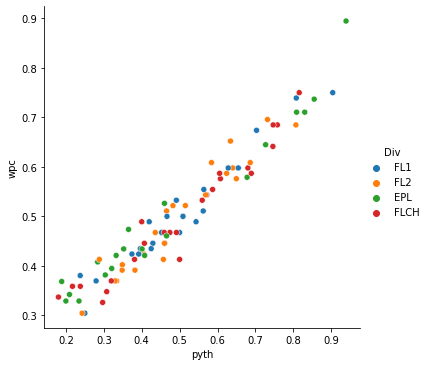

In [33]:
sns.relplot(x = "pyth", y = "wpc", data = Eng18, hue = "Div")

In [34]:
"""Find the Relation between Win % and Pythagorean Expectation using Regression: wpc = Intercept + Coef * pyth"""
#Generate a regression model (wpc as a function of pyth)
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data = Eng18).fit() #ols = Ordinary Least Squares (standard form of Regression)
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1265.
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           8.87e-55
Time:                        22:06:11   Log-Likelihood:                 187.39
No. Observations:                  92   AIC:                            -370.8
Df Residuals:                      90   BIC:                            -365.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1803      0.010     18.804      0.000       0.161       0.199
pyth           0.6502      0.018     35.561      0.000       0.614       0.687
==============================================================================
Omnibus:                        3.561   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.898
Skew:                           0.327   Prob(JB):                        0.235
Kurtosis:                       3.574   Cond. No.                         6.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### C. Interpreting Results

* Therefore: **wpc = 0.1803 + pyth * 0.6502**
    * For every unit increase in pyth, the wpc increases by 0.6502



* **Standard Error**: std err gives us an idea of the precision of the estimate
    * Here the standard error is much smaller (0.018)



* The p-value (P > |t|) is 0.000
    * Since p-value < 0.05 --> This value is considered statistically significant --> **There is statistical significance between Pythagorean Expectation and Win Percentage based on this dataset**
    
    

* R-squared value = 0.934:
    * Here the Pythagorean Expecation can account for 89.4% of the variation in win percentage. Even better fit than MLB data

* **Even when we took data from 4 different football leagues and merged them, we were able to show the pythagorean expectation theory holding true!**



* **The pythagorean principle held true for all the sports, except Cricket!**